In [1]:
import pandas as pd

In [15]:
df = pd.read_csv('./data/second_innings_updated.csv')
df

,match_id,venue,innings,ball,batting_team,bowling_team,runs_off_bat,extras,wides,noballs,byes,legbyes,wicket_type,runs_required,runs_scored,wickets_remaining,balls_remaining,crr,rrr,winner
0,1001349,Melbourne Cricket Ground,2,0.1,Sri Lanka,Australia,1,0,NaN,NaN,NaN,NaN,NaN,168.0,1.0,10.0,119.0,6.00,8.47,1.0
1,1001349,Melbourne Cricket Ground,2,0.2,Sri Lanka,Australia,0,1,NaN,NaN,NaN,1.0,NaN,167.0,2.0,10.0,118.0,6.00,8.49,1.0
2,1001349,Melbourne Cricket Ground,2,0.3,Sri Lanka,Australia,0,0,NaN,NaN,NaN,NaN,NaN,167.0,2.0,10.0,117.0,4.00,8.56,1.0
3,1001349,Melbourne Cricket Ground,2,0.4,Sri Lanka,Australia,0,0,NaN,NaN,NaN,NaN,NaN,167.0,2.0,10.0,116.0,3.00,8.64,1.0
4,1001349,Melbourne Cricket Ground,2,0.5,Sri Lanka,Australia,3,0,NaN,NaN,NaN,NaN,NaN,164.0,5.0,10.0,115.0,6.00,8.56,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301197,995469,R Premadasa Stadium,2,17.1,Australia,Sri Lanka,1,0,NaN,NaN,NaN,NaN,NaN,8.0,121.0,4.0,17.0,7.05,2.82,1.0
301198,995469,R Premadasa Stadium,2,17.2,Australia,Sri Lanka,3,0,NaN,NaN,NaN,NaN,NaN,5.0,124.0,4.0,16.0,7.15,1.88,1.0
301199,995469,R Premadasa Stadium,2,17.3,Australia,Sri Lanka,0,0,NaN,NaN,NaN,NaN,NaN,5.0,124.0,4.0,15.0,7.09,2.00,1.0
301200,995469,R Premadasa Stadium,2,17.4,Australia,Sri Lanka,0,0,NaN,NaN,NaN,NaN,NaN,5.0,124.0,4.0,14.0,7.02,2.14,1.0


In [16]:
df.drop(columns=['venue', 'innings', 'ball', 'batting_team', 'bowling_team', 'runs_off_bat', 'extras', 'wides', 'noballs', 'byes', 'legbyes', 'wicket_type'], inplace=True)
df.head()

,match_id,runs_required,runs_scored,wickets_remaining,balls_remaining,crr,rrr,winner
0,1001349,168.0,1.0,10.0,119.0,6.0,8.47,1.0
1,1001349,167.0,2.0,10.0,118.0,6.0,8.49,1.0
2,1001349,167.0,2.0,10.0,117.0,4.0,8.56,1.0
3,1001349,167.0,2.0,10.0,116.0,3.0,8.64,1.0
4,1001349,164.0,5.0,10.0,115.0,6.0,8.56,1.0


In [17]:
df.isna().sum()

match_id                0
runs_required           0
runs_scored             0
wickets_remaining       0
balls_remaining         0
crr                     0
rrr                     0
winner               4612
dtype: int64

In [18]:
df.dropna(inplace=True)

In [19]:
df.isna().sum()

match_id             0
runs_required        0
runs_scored          0
wickets_remaining    0
balls_remaining      0
crr                  0
rrr                  0
winner               0
dtype: int64

In [20]:
df.shape

(296590, 8)

In [21]:
df['runs_required'] = df['runs_required'].astype('int')
df['runs_scored'] = df['runs_scored'].astype('int')
df['wickets_remaining'] = df['wickets_remaining'].astype('int')
df['balls_remaining'] = df['balls_remaining'].astype('int')
df['winner'] = df['winner'].astype('int')

In [22]:
df.head()

,match_id,runs_required,runs_scored,wickets_remaining,balls_remaining,crr,rrr,winner
0,1001349,168,1,10,119,6.0,8.47,1
1,1001349,167,2,10,118,6.0,8.49,1
2,1001349,167,2,10,117,4.0,8.56,1
3,1001349,167,2,10,116,3.0,8.64,1
4,1001349,164,5,10,115,6.0,8.56,1


## Outlier Analysis

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fast')

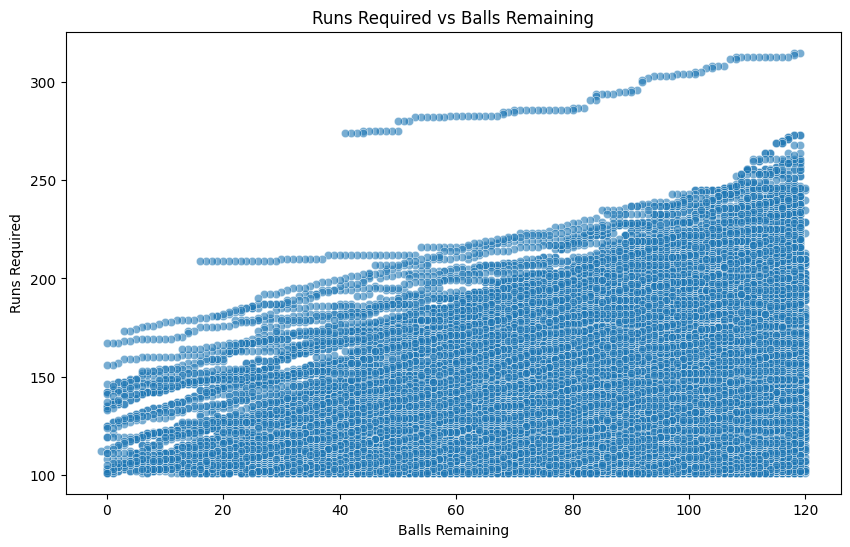

In [24]:
# scatter plot for runs required with minimum runs 100 vs balls remaining
plt.figure(figsize=(10, 6))
sns.scatterplot(x='balls_remaining', y='runs_required', data=df[(df['runs_required'] > 100)], alpha=0.6)
plt.title('Runs Required vs Balls Remaining')
plt.xlabel('Balls Remaining')
plt.ylabel('Runs Required')
plt.show()

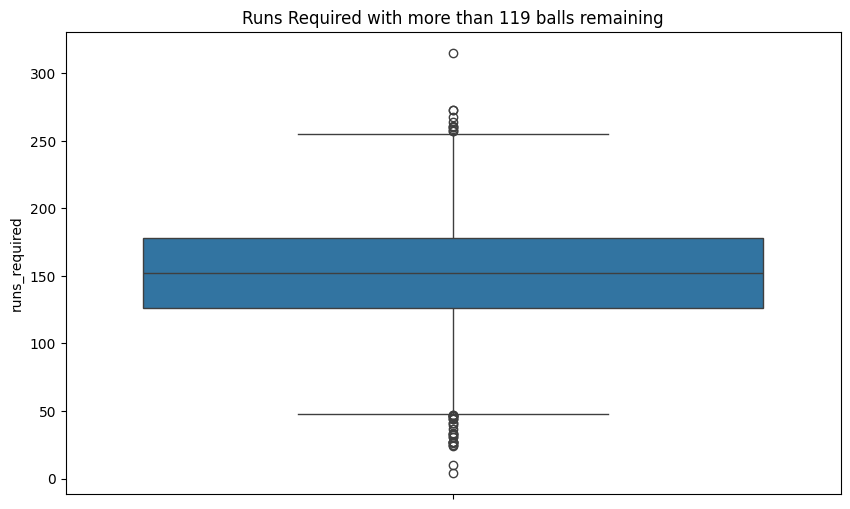

In [25]:
# boxplot for runs remaining with more than 119 balls remaining
plt.figure(figsize=(10, 6))
sns.boxplot(y='runs_required', data=df[(df['balls_remaining'] >= 119)])
plt.title('Runs Required with more than 119 balls remaining')
plt.show()

In [26]:
# get q1, q2, q3 for runs remaining with more than 119 balls remaining
q1 = df[(df['balls_remaining'] >= 119)]['runs_required'].quantile(0.25)
q2 = df[(df['balls_remaining'] >= 119)]['runs_required'].quantile(0.5)
q3 = df[(df['balls_remaining'] >= 119)]['runs_required'].quantile(0.75)

print(f'Q1: {q1}, Q2: {q2}, Q3: {q3}')

iqr = q3 - q1

# get lower and upper bounds
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)

print(f'Lower Bound: {lower_bound}, Upper Bound: {upper_bound}')

Q1: 126.0, Q2: 152.0, Q3: 178.0
Lower Bound: 48.0, Upper Bound: 256.0


In [27]:
# find match_id for outliers accordingly
outliers = df[(df['balls_remaining'] >= 119)][(df['runs_required'] < lower_bound) | (df['runs_required'] > upper_bound)]

outlier_matches = outliers['match_id'].unique()

outlier_matches

C:\Users\Rushabh Javeri\AppData\Local\Temp\ipykernel_17928\3550993586.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outliers = df[(df['balls_remaining'] >= 119)][(df['runs_required'] < lower_bound) | (df['runs_required'] > upper_bound)]


array([1122730, 1168113, 1176796, 1184901, 1273723, 1283030, 1299577,
       1310177, 1320974, 1322001, 1332506, 1343749, 1343756, 1343760,
       1343763, 1354803, 1373582, 1383101, 1383103, 1399104, 1400988,
       1418541, 1418543,  287860,  682933,  995467], dtype=int64)

In [28]:
df[df['match_id'].isin(outlier_matches)]

,match_id,runs_required,runs_scored,wickets_remaining,balls_remaining,crr,rrr,winner
9589,1122730,260,1,10,119,6.00,13.11,0
9590,1122730,260,1,10,118,3.00,13.22,0
9591,1122730,259,2,10,117,4.00,13.28,0
9592,1122730,258,3,10,116,4.50,13.34,0
9593,1122730,257,4,10,115,4.80,13.41,0
...,...,...,...,...,...,...,...,...
301087,995467,86,178,1,4,9.21,129.00,0
301088,995467,86,178,1,3,9.13,172.00,0
301089,995467,86,178,1,2,9.05,258.00,0
301090,995467,86,178,1,1,8.97,516.00,0


In [29]:
# drop where match id is in outlier_matches
df = df[~df['match_id'].isin(outlier_matches)]
df

,match_id,runs_required,runs_scored,wickets_remaining,balls_remaining,crr,rrr,winner
0,1001349,168,1,10,119,6.00,8.47,1
1,1001349,167,2,10,118,6.00,8.49,1
2,1001349,167,2,10,117,4.00,8.56,1
3,1001349,167,2,10,116,3.00,8.64,1
4,1001349,164,5,10,115,6.00,8.56,1
...,...,...,...,...,...,...,...,...
301197,995469,8,121,4,17,7.05,2.82,1
301198,995469,5,124,4,16,7.15,1.88,1
301199,995469,5,124,4,15,7.09,2.00,1
301200,995469,5,124,4,14,7.02,2.14,1


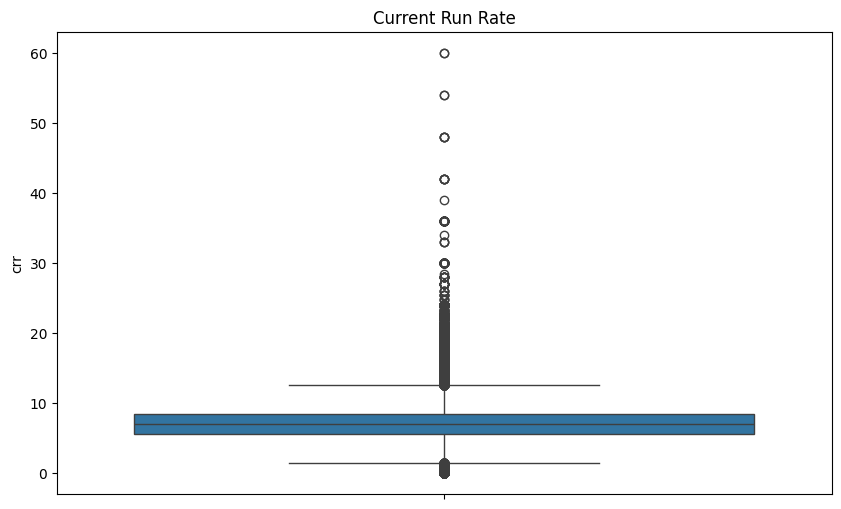

In [30]:
# boxplot for current run rate
plt.figure(figsize=(10, 6))
sns.boxplot(y='crr', data=df)
plt.title('Current Run Rate')
plt.show()

In [31]:
# get q1, q2, q3 for current run rate
q1 = df['crr'].quantile(0.25)
q2 = df['crr'].quantile(0.5)
q3 = df['crr'].quantile(0.75)

print(f'Q1: {q1}, Q2: {q2}, Q3: {q3}')

iqr = q3 - q1

# get lower and upper bounds
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)

print(f'Lower Bound: {lower_bound}, Upper Bound: {upper_bound}')

Q1: 5.63, Q2: 6.97, Q3: 8.42
Lower Bound: 1.4449999999999994, Upper Bound: 12.605


In [32]:
# remove outliers
df = df[(df['crr'] > lower_bound) & (df['crr'] < upper_bound)]

print(df['crr'].min())
print(df['crr'].max())

1.46
12.6


In [33]:
# sort df by rrr
df.sort_values(by='rrr', ascending=True).head()

,match_id,runs_required,runs_scored,wickets_remaining,balls_remaining,crr,rrr,winner
177453,1321465,112,125,3,-1,6.20,-672.0,0
216227,1384593,42,146,1,-1,7.24,-252.0,0
196617,1344794,33,123,4,-1,6.10,-198.0,0
301201,995469,0,130,4,13,7.29,0.0,1
199998,1349390,0,165,9,36,11.79,0.0,1


In [34]:
# remove values where balls remaining is less than 0
df = df[df['balls_remaining'] >= 0]

In [35]:
df['rrr'].min()

0.0

In [36]:
df.sort_values(by='rrr', ascending=False).head(15)

,match_id,runs_required,runs_scored,wickets_remaining,balls_remaining,crr,rrr,winner
173402,1321272,167,44,3,0,2.20,1002.0,0
173401,1321272,167,44,3,1,2.22,1002.0,0
179632,1321998,156,58,2,1,2.92,936.0,0
179633,1321998,156,58,2,0,2.90,936.0,0
149039,1286670,146,89,5,1,4.49,876.0,0
149040,1286670,146,89,4,0,4.45,876.0,0
149768,1286677,145,95,2,1,4.79,870.0,0
41760,1208606,143,94,4,1,4.74,858.0,0
111938,1208606,143,94,4,1,4.74,858.0,0
41761,1208606,142,95,4,0,4.75,852.0,0


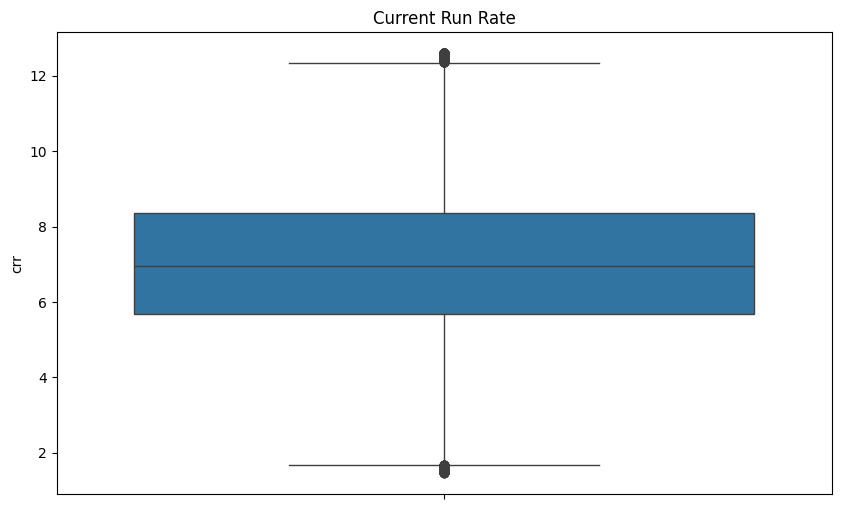

In [37]:
# boxplot for required run rate
plt.figure(figsize=(10, 6))
sns.boxplot(y='crr', data=df)
plt.title('Current Run Rate')
plt.show()

In [38]:
# get q1, q2, q3 for required run rate
q1 = df['rrr'].quantile(0.25)
q2 = df['rrr'].quantile(0.5)
q3 = df['rrr'].quantile(0.75)

print(f'Q1: {q1}, Q2: {q2}, Q3: {q3}')

iqr = q3 - q1

# get lower and upper bounds
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)

print(f'Lower Bound: {lower_bound}, Upper Bound: {upper_bound}')

Q1: 6.35, Q2: 8.5, Q3: 11.0
Lower Bound: -0.6250000000000009, Upper Bound: 17.975


In [39]:
df[df['rrr'] > upper_bound].shape

(20892, 8)

In [40]:
df = df[(df['rrr'] > lower_bound) & (df['rrr'] < upper_bound)]

In [41]:
df['rrr'].max()

17.91

In [42]:
df.shape

(263074, 8)

## Model Building

In [49]:
# preprocessing for model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X_cols = ['runs_required', 'wickets_remaining', 'crr', 'rrr', 'balls_remaining']

X = df[X_cols]
# X = df[['runs_required', 'wickets_remaining', 'balls_remaining']]
y = df['winner']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [50]:
# logistic regression model
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

In [51]:
accuracy = lr_model.score(X_test, y_test)
accuracy

0.8195761664924451

In [52]:
print(X_test[10])
lr_model.predict_proba(X_test)[10]

[0.41269841 0.9        0.77448338 0.47738693 0.60833333]


array([0.29498366, 0.70501634])

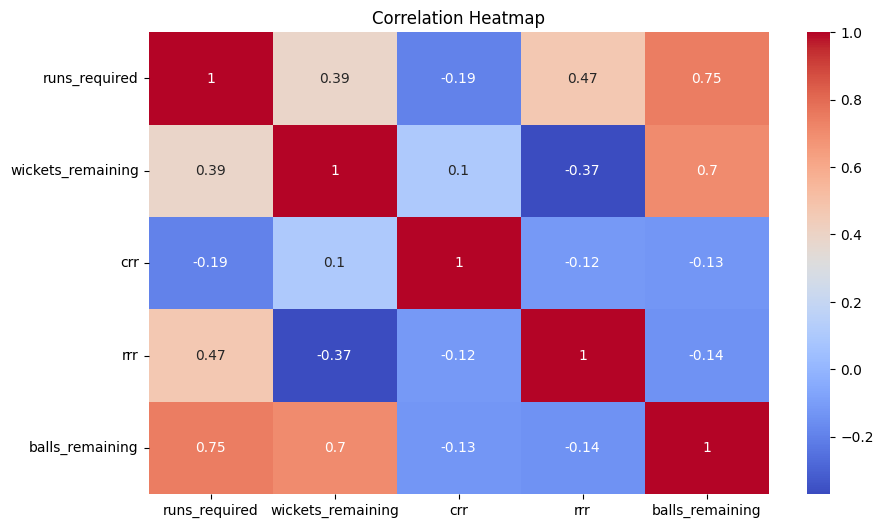

In [53]:
# correlation
corr = df[X_cols].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [56]:
# test for custom input
# custom_data = [193, 10, 7, 9.8135593220, 118]
# custom_data = [10, 1, 5, 2.4, 1]
custom_data = [74, 7, 7, 8.7, 51]

# scale custom data
custom_data = scaler.transform([custom_data])

print(lr_model.predict(custom_data))

batting_team_probability = lr_model.predict_proba(custom_data)[0][1]
bowling_team_probability = lr_model.predict_proba(custom_data)[0][0]

print(f'Batting Team Probability: {batting_team_probability}')
print(f'Bowling Team Probability: {bowling_team_probability}')

[1]
Batting Team Probability: 0.5253112842024031
Bowling Team Probability: 0.47468871579759686


c:\Users\Rushabh Javeri\Sem-10\NNDL\Project\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [57]:
import pickle
import joblib

In [58]:
joblib.dump(scaler, './models/scaler.pkl')

['./models/scaler.pkl']

In [59]:
# load the scaler
scaler = joblib.load('./models/scaler.pkl')

# test on custom data
test_data = [[100, 5, 10, 10, 100]]
test_data = scaler.transform(test_data)

test_data

c:\Users\Rushabh Javeri\Sem-10\NNDL\Project\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


array([[0.3968254 , 0.5       , 0.76639712, 0.55834729, 0.83333333]])

### Test model over ranges of overs

In [60]:
# make a function for above 5 cells
def get_accuracy(model, data):
    X = data[['runs_required', 'wickets_remaining', 'crr', 'rrr', 'balls_remaining']]
    y = data['winner']

    X = scaler.transform(X)

    accuracy = model.score(X, y)
    return accuracy

def test_over_overs_5(model):
    first_5_overs = df[(df['balls_remaining'] >= 90)].copy()
    overs_5_10 = df[(df['balls_remaining'] >= 60) & (df['balls_remaining'] < 90)].copy()
    overs_10_15 = df[(df['balls_remaining'] >= 30) & (df['balls_remaining'] < 60)].copy()
    overs_15_20 = df[(df['balls_remaining'] < 30)].copy()

    first_5_overs_accuracy = get_accuracy(model, first_5_overs)
    overs_5_10_accuracy = get_accuracy(model, overs_5_10)
    overs_10_15_accuracy = get_accuracy(model, overs_10_15)
    overs_15_20_accuracy = get_accuracy(model, overs_15_20)

    return first_5_overs_accuracy, overs_5_10_accuracy, overs_10_15_accuracy, overs_15_20_accuracy

In [61]:
#write test_over_overs for 4 overs instead of 5

def test_over_overs_4(model):
    first_4_overs = df[(df['balls_remaining'] >= 96)].copy()
    overs_4_8 = df[(df['balls_remaining'] >= 72) & (df['balls_remaining'] < 96)].copy()
    overs_8_12 = df[(df['balls_remaining'] >= 48) & (df['balls_remaining'] < 72)].copy()
    overs_12_16 = df[(df['balls_remaining'] >= 24) & (df['balls_remaining'] < 48)].copy()
    overs_16_20 = df[(df['balls_remaining'] < 24)].copy()

    first_4_overs_accuracy = get_accuracy(model, first_4_overs)
    overs_4_8_accuracy = get_accuracy(model, overs_4_8)
    overs_8_12_accuracy = get_accuracy(model, overs_8_12)
    overs_12_16_accuracy = get_accuracy(model, overs_12_16)
    overs_16_20_accuracy = get_accuracy(model, overs_16_20)

    return first_4_overs_accuracy, overs_4_8_accuracy, overs_8_12_accuracy, overs_12_16_accuracy, overs_16_20_accuracy

In [63]:
acc_0_5, acc_5_10, acc_10_15, acc_15_20 = test_over_overs_5(lr_model)

print(f'First  Overs Accuracy: {acc_0_5}')
print(f'5-10 Overs Accuracy: {acc_5_10}')
print(f'10-15 Overs Accuracy: {acc_10_15}')
print(f'15-20 Overs Accuracy: {acc_15_20}')

First  Overs Accuracy: 0.7628612907483173
5-10 Overs Accuracy: 0.8155030099919319
10-15 Overs Accuracy: 0.8589230704896782
15-20 Overs Accuracy: 0.868421052631579


In [64]:
acc_0_4, acc_4_8, acc_8_12, acc_12_16, acc_16_20 = test_over_overs_4(lr_model)

print(f'First 4 Overs Accuracy: {acc_0_4}')
print(f'4-8 Overs Accuracy: {acc_4_8}')
print(f'8-12 Overs Accuracy: {acc_8_12}')
print(f'12-16 Overs Accuracy: {acc_12_16}')
print(f'16-20 Overs Accuracy: {acc_16_20}')

First 4 Overs Accuracy: 0.7543638169300948
4-8 Overs Accuracy: 0.8034001475651746
8-12 Overs Accuracy: 0.8386926219658736
12-16 Overs Accuracy: 0.8688390184376609
16-20 Overs Accuracy: 0.8640670400471638


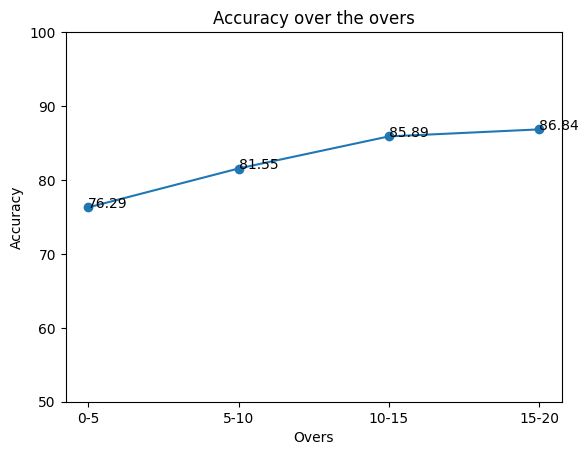

In [65]:
x = ['0-5', '5-10', '10-15', '15-20']
y = [acc_0_5 * 100, acc_5_10 * 100, acc_10_15 * 100, acc_15_20 * 100]

plt.plot(x, y, marker='o')
plt.ylim(50, 100)
plt.title('Accuracy over the overs')
plt.xlabel('Overs')
for i in range(len(x)):
    plt.text(x[i], y[i], round(y[i],2))
plt.ylabel('Accuracy')
plt.show()

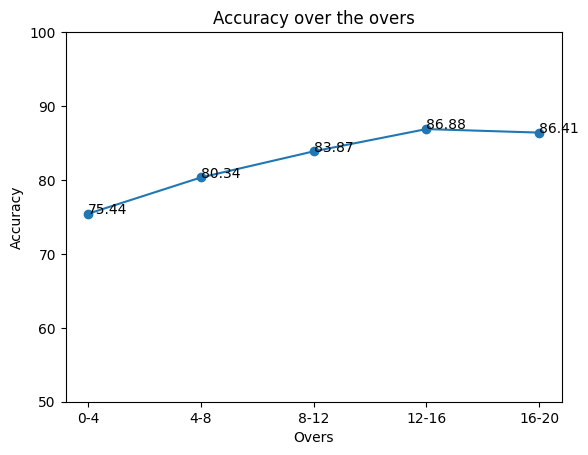

In [66]:
#Plot for 4 overs
x = ['0-4', '4-8', '8-12', '12-16', '16-20']
y = [acc_0_4 * 100, acc_4_8 * 100, acc_8_12 * 100, acc_12_16 * 100, acc_16_20 * 100]

plt.plot(x, y, marker='o')
plt.ylim(50, 100)
plt.title('Accuracy over the overs')
plt.xlabel('Overs')
for i in range(len(x)):
    plt.text(x[i], y[i], round(y[i],2))
plt.ylabel('Accuracy')
plt.show()

In [81]:
pickle.dump(lr_model, open('./models/logistic_regression.pkl', 'wb'))

## Random Forest

In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [69]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)

RandomForestClassifier()

In [70]:
rf_classifier.score(X_test, y_test)

0.8935664734391333

In [75]:
print(X_test[11])

print(rf_classifier.predict(X_test[11].reshape(1, -1)))

batting_team_probability = rf_classifier.predict_proba(X_test)[11][1]
bowling_team_probability = rf_classifier.predict_proba(X_test)[11][0]

print(f'Batting Team Probability: {batting_team_probability}')
print(f'Bowling Team Probability: {bowling_team_probability}')

[0.33333333 0.9        0.71608266 0.54103853 0.43333333]
[1]
Batting Team Probability: 0.94
Bowling Team Probability: 0.06


In [80]:
custom_data = [74, 7, 7, 14.8, 30]
custom_data = scaler.transform([custom_data])

print(rf_classifier.predict(custom_data))

batting_team_probability = rf_classifier.predict_proba(custom_data)[0][1]
bowling_team_probability = rf_classifier.predict_proba(custom_data)[0][0]

print(f'Batting Team Probability: {batting_team_probability}')
print(f'Bowling Team Probability: {bowling_team_probability}')

[0]
Batting Team Probability: 0.21
Bowling Team Probability: 0.79


c:\Users\Rushabh Javeri\Sem-10\NNDL\Project\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [82]:
# save model
pickle.dump(rf_classifier, open('./models/random_forest.pkl', 'wb'))

In [83]:
# test for 5 over intervals
acc_0_5, acc_5_10, acc_10_15, acc_15_20 = test_over_overs_5(rf_classifier)

print(f'First 5 Overs Accuracy: {acc_0_5}')
print(f'5-10 Overs Accuracy: {acc_5_10}')
print(f'10-15 Overs Accuracy: {acc_10_15}')
print(f'15-20 Overs Accuracy: {acc_15_20}')

First 5 Overs Accuracy: 0.931080902731952
5-10 Overs Accuracy: 0.9754608080431949
10-15 Overs Accuracy: 0.9823113700673255
15-20 Overs Accuracy: 0.9841419509686268


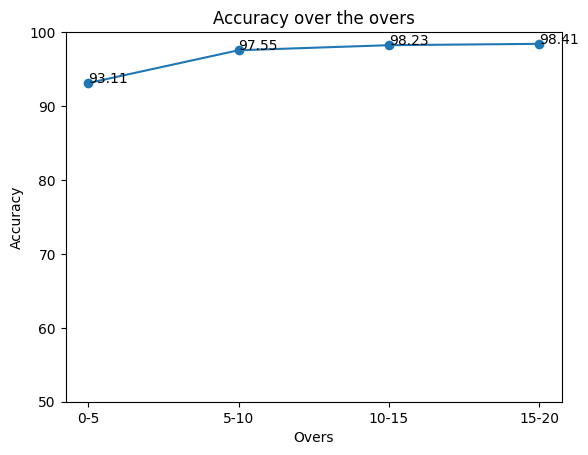

In [85]:
# plot
x = ['0-5', '5-10', '10-15', '15-20']
y = [acc_0_5 * 100, acc_5_10 * 100, acc_10_15 * 100, acc_15_20 * 100]

plt.plot(x, y, marker='o')
plt.ylim(50, 100)
plt.title('Accuracy over the overs')
plt.xlabel('Overs')
for i in range(len(x)):
    plt.text(x[i], y[i], round(y[i],2))
plt.ylabel('Accuracy')
plt.show()

In [84]:
# test for 4 over intervals
acc_0_4, acc_4_8, acc_8_12, acc_12_16, acc_16_20 = test_over_overs_4(rf_classifier)

print(f'First 4 Overs Accuracy: {acc_0_4}')
print(f'4-8 Overs Accuracy: {acc_4_8}')
print(f'8-12 Overs Accuracy: {acc_8_12}')
print(f'12-16 Overs Accuracy: {acc_12_16}')
print(f'16-20 Overs Accuracy: {acc_16_20}')

First 4 Overs Accuracy: 0.9229578010065815
4-8 Overs Accuracy: 0.9697798819478604
8-12 Overs Accuracy: 0.9798125450612833
12-16 Overs Accuracy: 0.9841554331038954
16-20 Overs Accuracy: 0.9836189834505411


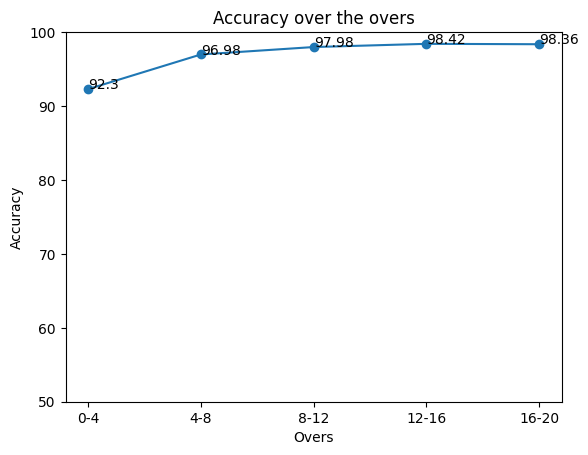

In [86]:
# plot
x = ['0-4', '4-8', '8-12', '12-16', '16-20']
y = [acc_0_4 * 100, acc_4_8 * 100, acc_8_12 * 100, acc_12_16 * 100, acc_16_20 * 100]

plt.plot(x, y, marker='o')
plt.ylim(50, 100)
plt.title('Accuracy over the overs')
plt.xlabel('Overs')
for i in range(len(x)):
    plt.text(x[i], y[i], round(y[i],2))
plt.ylabel('Accuracy')
plt.show()

## Feedforward Neural Network with 1 hidden layer

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2

In [ ]:
# predict
y_pred = fnn_1l_model.predict(X_test)

loss, accuracy = fnn_1l_model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

In [ ]:
# test for custom input
# custom_data = [10, 5, 60, 1]
custom_data = [70, 8, 6, 8.4, 50]

# scale custom data
custom_data = scaler.transform([custom_data])

batting_team_probability = fnn_1l_model.predict(custom_data)[0][0]
bowling_team_probability = 1 - batting_team_probability

print(f'Batting Team Probability: {batting_team_probability}')
print(f'Bowling Team Probability: {bowling_team_probability}')

In [ ]:
fnn_2l_model = Sequential()

fnn_2l_model.add(Dense(4, activation='tanh'))
fnn_2l_model.add(Dense(64, activation='tanh'))
fnn_2l_model.add(Dense(32, activation='tanh'))
fnn_2l_model.add(Dense(1, activation='sigmoid'))

fnn_2l_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

fnn_2l_model.fit(X_train, y_train, epochs=10, verbose=1)

In [ ]:
# predict
y_pred = fnn_2l_model.predict(X_test)

loss, accuracy = fnn_2l_model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')